# Curation, selection and validation of 4CV frame labels

**Author(s):** Miguel Xochicale [@mxochicale](https://github.com/mxochicale)  
**Contributor(s):** Nhat Phug [@huynhatd13](https://github.com/huynhatd13) 

March2022; April2022


## Introduction
This notebook presents prototypes to pre-process echocardiography datasets with the use of pytorch features. 

### Running notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### References
* "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML)-Based Software as a Medical Device (SaMD) - Discussion Paper and Request for Feedback". https://www.fda.gov/media/122535/download 
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 




## Jupyter Notebook

### Setting imports and datasets paths

In [48]:
import os
import sys
import argparse
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())
from tqdm import tqdm
import shutil

import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.models.learning_misc import train_loop, test_loop
from source.helpers.various import concatenating_YAML_via_tags, plot_dataset_classes, split_train_validate_sets


HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]
CONFIG_FILES_PATH= 'repositories/echocardiography/scripts/config_files/users_paths_files'
YML_FILE =  'config_users_paths_files_username_' + USERNAME + '_validation'+ '.yml'
FULL_PATH_FOR_YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, YML_FILE)

subjectsCSV_PATH = 'datasets/vital-us/echocardiography/subjectsCSV/anonimised'
CSV_FILE = 'validation_anonymised_april2022.csv'
FULL_PATH_FOR_CSV_FILE = os.path.join(HOME_PATH, subjectsCSV_PATH, CSV_FILE)
datatablea_validation_anonymised = pd.read_csv(FULL_PATH_FOR_CSV_FILE)

yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler
with open(FULL_PATH_FOR_YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)


print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)    


PyTorch Version:  1.9.0
Torchvision Version:  0.10.0a0


### Splitting datasets

In [49]:
split_train_validate_sets(  
                        config['echodataset_path'], 
                        config['data_list_output_path'], 
                        config['ntraining'],
                        config['randomise_file_list']
                        )


======= video_filenames: ['01NVb-003-040/T1/01NVb-003-040-1 echo.mp4', '01NVb-003-040/T2/01NVb-003-040-2 echo.mp4', '01NVb-003-041/T1/01NVb-003-041-1 echo.mp4', '01NVb-003-041/T2/01NVb-003-041-2 echo.mp4', '01NVb-003-041/T3/01NVb-003-041-3 echo.mp4', '01NVb-003-042/T1/01NVb-003-042-1 echo.mp4', '01NVb-003-042/T2/01NVb-003-042-2 echo.mp4', '01NVb-003-042/T3/01NVb-003-042-3 echo.mp4', '01NVb-003-043/T1/01NVb-003-043-1 echo.mp4', '01NVb-003-043/T1/01NVb-003-043-2 echo.mp4', '01NVb-003-043/T3/01NVb-003-043-3 echo.mp4', '01NVb-003-044/T1/01NVb-003-044-2 echo.mp4', '01NVb-003-044/T3/01NVb-003-044-3 echo.mp4', '01NVb-003-045/T1/01NVb-003-045-1 echo.mp4', '01NVb-003-045/T2/01NVb-003-045-3 echo.mp4', '01NVb-003-045/T3/01NVB-003-045-2 echo.mp4', '01NVb-003-046/T1/01NVb-003-046-1 echo.mp4', '01NVb-003-046/T2/01NVb-003-046-2 echo.mp4', '01NVb-003-046/T3/01NVb-003-046-3 echo.mp4', '01NVb-003-047/T1/01NVb-003-047-1 echo.mp4', '01NVb-003-047/T2/01NVb-003-047-2 echo.mp4', '01NVb-003-047/T3/01NVb-003-0

# Verification of participants

In [50]:

SUBJECT_ID = '040'
NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") #or "cuda:0"


#preis=config['pretransform_im_size']
#print(preis[0], preis[1])


videolist = config['participant_videos_list_full']
annotationlist = config['participant_path_json_list_full']

video_filenames = [line.strip() for line in open(videolist)]
annotation_filenames = [line.strip() for line in open(annotationlist)]

echodataset_path= config['echodataset_path']
data_list_output_path = config['data_list_output_path']
#print(echodataset_path)
#print(data_list_output_path)

all_videos_files_to_be_verified = 'video_list_tbv.txt'
all_annotation_files_to_be_verified = 'annotation_list_tbv.txt'
videolist_tbv_txt = '{}{}'.format(data_list_output_path, all_videos_files_to_be_verified)
annotationlist_tbv_txt = '{}{}'.format(data_list_output_path, all_annotation_files_to_be_verified)

JSON_FILE_PATTERN = '*'+SUBJECT_ID+'*4[cC][vV].[jJ][sS][oO][nN]'
MP4_FILE_PATTERN = '*'+SUBJECT_ID+'*echo*.[mM][pP][4]'

result = list(sorted(Path(echodataset_path).rglob(MP4_FILE_PATTERN)))
with open(videolist_tbv_txt, 'w') as file_list_txt:
    for mp4_filename_i in result:
        file_n_nopath = str(mp4_filename_i).replace(echodataset_path, '')
        file_list_txt.write(file_n_nopath + '\n')
        

result = list(sorted(Path(echodataset_path).rglob(JSON_FILE_PATTERN)))
with open(annotationlist_tbv_txt, 'w') as file_list_txt:
    for mp4_filename_i in result:
        file_n_nopath = str(mp4_filename_i).replace(echodataset_path, '')
        file_list_txt.write(file_n_nopath + '\n')        
        

### Setting variables and loading datasets using pytorch dataloader

In [51]:
# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_image_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=config['pretransform_im_size']),
        transforms.ToTensor(),
    ])
else:
    pretransform = None

# These transforms have random parameters changing at each epoch.
if config['use_train_augmentation']:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(), 
    ])
else:
    transform = None
    

train_dataset = EchoClassesDataset(
    echodataset_path=config['echodataset_path'],
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_tbv'],
    participant_path_json_list=config['participant_path_json_list_tbv'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=config['pretransform_im_size'],
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP,
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    transform=None,
    use_tmp_storage=config['use_tmp_storage'],
    )


### Plotting Class Distribution


{'BKGR': 5, '4CV': 5}


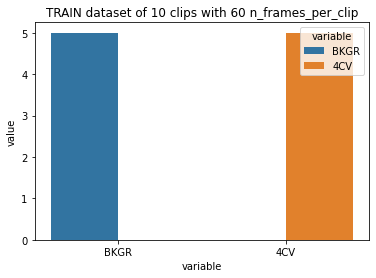

In [52]:
label_id = ('BKGR', '4CV')
number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip'] 

def get_class_distribution(dataset_obj):
    count_class_dict = {
   'BKGR': 0 ,
   "4CV": 0
    }
    
    for clip_index_i in range(len(dataset_obj)):
        data_idx = dataset_obj[clip_index_i]
        label_id_idx = data_idx[1]
        label = label_id[label_id_idx]
        count_class_dict[label]+= 1
        #count_class_dict[label]+= 1* number_of_frames_per_segment_in_a_clip

    return count_class_dict
        
        
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), 
                       x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


print(get_class_distribution(train_dataset))

plot_title_train_label= f'TRAIN dataset of {len(train_dataset)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'
#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18,7))
plot_from_dict(get_class_distribution(train_dataset), plot_title=plot_title_train_label)
plt.show()


### Animating frames of one clip of the dataloader

Clip Size of data_clip_idx[1].size() torch.Size([1, 650, 690]) of 4CV label


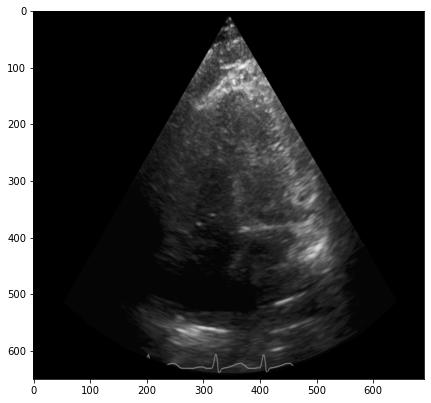

In [53]:
#average_HR =
#fps = 30
# 60 # beats per minute 
#Beats-per-minute: 60 BPM
#Beats-per-second: 1 Hz
#Cycle-per-second: 1 (Cycle/s)

clip_idx = 6
data_clip_idx = train_dataset[clip_idx][0]
data_clip_label = train_dataset[clip_idx][1]
print(f'Clip Size of data_clip_idx[1].size() {data_clip_idx[:,1,...].size()} of {label_id[data_clip_label]} label')

### Animating data_clip_idx 
interval_between_frames_in_milliseconds=100
fig = plt.figure(figsize=(7, 7))
frames = [[plt.imshow(data_clip_idx[:,i,...].cpu().detach().numpy().transpose(1,2,0) , cmap=plt.get_cmap('gray') )] for i in range(data_clip_idx[:,:,...].size()[1]) ]
anim = animation.ArtistAnimation(fig, frames, interval=interval_between_frames_in_milliseconds, blit=True, repeat_delay=1000)
HTML(anim.to_jshtml())

# ### Save animation as gif (if required) or other formats https://holypython.com/how-to-save-matplotlib-animations-the-ultimate-guide/
# f = r"/home/mx19/repositories/echocardiography/scripts/learning-pipeline/animation.gif" 
# writergif = animation.PillowWriter(fps=30) 
# writergif2='imagemagick'
# anim.save(f, dpi=80, writer=writergif)


### Displayting frames in the dataloader

In [54]:
BATCH_SIZE_OF_CLIPS = 4

print(f' train_dataset.__len__() = {train_dataset.__len__()}')
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)


for clip_batch_idx, sample_batched in enumerate(train_dataloader):
    print(f'====================================================')
    sample_batched_images=sample_batched[0]
    sample_batched_labels=sample_batched[1]
    print(f'BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
    print(f'SAMPLE_IDX_LABELS: {  sample_batched_labels  }')
    print(f'SAMPLE_BATCH: {sample_batched_images.size()}')
    
    sample_batched=sample_batched_images #.squeeze()
    print(f'SAMPLE_BATCH.squeeze: {sample_batched.size()}')
    
    for BATCH_SIZE_IDX, label in enumerate(sample_batched_labels):
        print(f'   BATCH_SIZE_IDX {BATCH_SIZE_IDX} label: {label}')
        sample_batched_idx_image = sample_batched[BATCH_SIZE_IDX,...]
        print(f'   Sample_batched_idx_image.size()  {sample_batched_idx_image.size() }'  )
        
        grid = utils.make_grid(sample_batched_idx_image)
        print(f'   Grid size {grid.size()}' )
#         plt.figure(figsize =(20,20) )
#         plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
#         plt.title(f'BATCH_SIZE_IDX {BATCH_SIZE_IDX}; Label: {label_id[label]}')
#         plt.axis('off')
#         plt.ioff()
#         plt.show()



 train_dataset.__len__() = 10
BATCH_OF_CLIPS_INDEX: 0 
SAMPLE_IDX_LABELS: tensor([0, 1, 0, 0])
SAMPLE_BATCH: torch.Size([4, 1, 30, 650, 690])
SAMPLE_BATCH.squeeze: torch.Size([4, 1, 30, 650, 690])
   BATCH_SIZE_IDX 0 label: 0
   Sample_batched_idx_image.size()  torch.Size([1, 30, 650, 690])
   Grid size torch.Size([30, 650, 690])
   BATCH_SIZE_IDX 1 label: 1
   Sample_batched_idx_image.size()  torch.Size([1, 30, 650, 690])
   Grid size torch.Size([30, 650, 690])
   BATCH_SIZE_IDX 2 label: 0
   Sample_batched_idx_image.size()  torch.Size([1, 30, 650, 690])
   Grid size torch.Size([30, 650, 690])
   BATCH_SIZE_IDX 3 label: 0
   Sample_batched_idx_image.size()  torch.Size([1, 30, 650, 690])
   Grid size torch.Size([30, 650, 690])
BATCH_OF_CLIPS_INDEX: 1 
SAMPLE_IDX_LABELS: tensor([1, 1, 1, 0])
SAMPLE_BATCH: torch.Size([4, 1, 30, 650, 690])
SAMPLE_BATCH.squeeze: torch.Size([4, 1, 30, 650, 690])
   BATCH_SIZE_IDX 0 label: 1
   Sample_batched_idx_image.size()  torch.Size([1, 30, 650, 690])
 

# List of files to be verified

**Instructions: Tick the box once it is verified. If there are comments, please add them at the end of each line.**


* [x] 040 {'BKGR': 5, '4CV': 5}
* [ ] 040 - T1-??clips; 
* [ ] 040 - T2-??clips; 
* [ ] 040 - T3-??clips; 
* ---
* [ ] 041 - T1-??clips; 
* [ ] 041 - T2-??clips; 
* [ ] 041 - T3-??clips; 
* ---
* [ ] 042 - T1-??clips; 
* [ ] 042 - T2-??clips; 
* [ ] 042 - T3-??clips; 
* ---
* [ ] 043 - T1-??clips; 
* [ ] 043 - T2-??clips; 
* [ ] 043 - T3-??clips; 
* ---
* [ ] 044 - T1-??clips; 
* [ ] 044 - T2-??clips; 
* [ ] 044 - T3-??clips; 
* ---
* [ ] 045 - T1-??clips; 
* [ ] 045 - T2-??clips; 
* [ ] 045 - T3-??clips; 
* ---
* [ ] 046 - T1-??clips; 
* [ ] 046 - T2-??clips; 
* [ ] 046 - T3-??clips; 
* ---
* [ ] 047 - T1-??clips; 
* [ ] 047 - T2-??clips; 
* [ ] 047 - T3-??clips; 
* ---
* [ ] 048 - T1-??clips; 
* [ ] 048 - T2-??clips; 
* [ ] 048 - T3-??clips; 
* ---
* [ ] 049 - T1-??clips; 
* [ ] 049 - T2-??clips; 
* [ ] 049 - T3-??clips; 

=================== LABELLED =======================


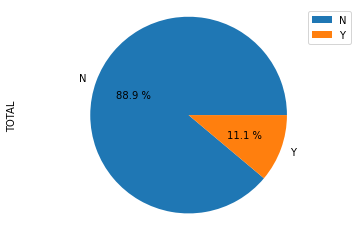

In [55]:

## Filtering columns
basic_demographics=datatablea_validation_anonymised.filter(items=[ 'SUBJID', 'LABELLED', 'CLIPS_DAY01', 'CLIPS_DAY02', 'CLIPS_DAY02'])
basic_demographics


print(f'=================== LABELLED =======================')
basic_demographics['LABELLED'].value_counts().plot.pie(autopct='%.1f %%', ylabel='TOTAL', legend=True)
plt.axis('equal')
plt.show()

## [**!WARNING!**] Cleanup temporal data directory 
Remove directory if a temporary was used.



```
       Make sure you know which path you will remove as you do not like to remove important files.
       shutil.rmtree
```

In [56]:
temporal_files_path = config['temporal_data_path']

shutil.rmtree(temporal_files_path)
print(f' {temporal_files_path} is empty')


 /home/mx19/datasets/vital-us/echocardiography/temporal-files/ is empty


## TO BE VERIFIED


* =======================
* [ ] 050 - T1-??clips; 
* [ ] 050 - T2-??clips; 
* [ ] 050 - T3-??clips; 
* ---
* [ ] 051 - T1-??clips; 
* [ ] 051 - T2-??clips; 
* [ ] 051 - T3-??clips; 
* ---
* [ ] 052 - T1-??clips; 
* [ ] 052 - T2-??clips; 
* [ ] 052 - T3-??clips; 
* ---
* [ ] 053 - T1-??clips; 
* [ ] 053 - T2-??clips; 
* [ ] 053 - T3-??clips; 
* ---
* [ ] 054 - T1-??clips; 
* [ ] 054 - T2-??clips; 
* [ ] 054 - T3-??clips; 
* ---
* [ ] 055 - T1-??clips; 
* [ ] 055 - T2-??clips; 
* [ ] 055 - T3-??clips; 
* ---
* [ ] 056 - T1-??clips; 
* [ ] 056 - T2-??clips; 
* [ ] 056 - T3-??clips; 
* ---
* [ ] 057 - T1-??clips; 
* [ ] 057 - T2-??clips; 
* [ ] 057 - T3-??clips; 
* ---
* [ ] 058 - T1-??clips; 
* [ ] 058 - T2-??clips; 
* [ ] 058 - T3-??clips; 
* ---
* [ ] 059 - T1-??clips; 
* [ ] 059 - T2-??clips; 
* [ ] 059 - T3-??clips; 
* =======================
* [ ] 060 - T1-01clips; 
* [ ] 060 - T2-00clips; 
* [ ] 060 - T3-00clips
* ---
* [ ] 061 - T1-00clips; 
* [ ] 061 - T2-00clips; 
* [ ] 061 - T3-01clips
* ---
* [ ] 061 - T1-02clips; 
* [ ] 061 - T2-02clips; 
* [ ] 061 - T3-01clips
* ---
* [ ] 064 - T1-02clips; 
* [ ] 064 - T2-03clips; 
* [ ] 064 - T3-00clips
* ---
* [ ] 065 - T1-02clips; 
* [ ] 065 - T2-04clips; 
* [ ] 065 - T3-05clips
* ---
* [ ] 066 - T1-01clips; 
* [ ] 066 - T2-02clips; 
* [ ] 066 - T3-00clips
* ---
* [ ] 067 - T1-00clips; 
* [ ] 067 - T2-00clips; 
* [ ] 067 - T3-00clips
* ---
* [ ] 068 - T1-02clips; 
* [ ] 068 - T2-00clips; 
* [ ] 068 - T3-02clips
* ---
* [ ] 069 - T1-02clips; 
* [ ] 069 - T2-03clips; 
* [ ] 069 - T3-02clips
* =======================
* [ ] 070 - T1-04clips; 
* [ ] 070 - T2-04clips; 
* [ ] 070 - T3-01clips 
* ---
* [ ] 071 - T1-00clips; 
* [ ] 071 - T2-02clips; 
* [ ] 071 - T3-01clips
* ---
* [ ] 072 - T1-01clips; 
* [ ] 072 - T2-03clips; 
* [ ] 072 - T3-02clips
* ---
* [ ] 073 - T1-02clips; 
* [ ] 073 - T2-01clips; 
* [ ] 073 - T3-00clips
* ---
* [ ] 074 - T1-02clips; 
* [ ] 074 - T2-02clips; 
* [ ] 074 - T3-00clips
* ---
* [ ] 075 - T1-01clips; 
* [ ] 075 - T2-02clips; 
* [ ] 075 - T3-02clips
* ---
* [ ] 076 - T1-01clips; 
* [ ] 076 - T2-01clips; 
* [ ] 076 - T3-02clips
* ---
* [ ] 077 - T1-00clips; 
* [ ] 077 - T2-00clips; 
* [ ] 077 - T3-00clips
* ---
* [ ] 078 - T1-01clips; 
* [ ] 078 - T2-01clips; 
* [ ] 078 - T3-01clips
* ---
* [ ] 079 - T1-01clips; 
* [ ] 079 - T2-02clips; 
* [ ] 079 - T3-01clips
* ---
* [ ] 080 - T1-00clips; 
* [ ] 080 - T2-00clips; 
* [ ] 080 - T3-00clips
* =======================
* [ ] 081 - T1-00clips; 
* [ ] 081 - T2-00clips; 
* [ ] 081 - T3-00clips
